In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from src.infra import config

path = '../../config/vec.yaml'
opt = config.load_config(path)
opt.path = path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Dataset & dataloader

In [5]:
from pathlib import Path

data_root = Path('/home/knpob/Documents/Hinton/data/shape-corr/FAUST_r')

In [6]:
from src.dataset.shape_cor_fast import PairFaustDatasetFast

dataset = PairFaustDatasetFast(
    data_root=data_root,
    phase='train',
    return_faces=True,
    return_L=True,
    return_mass=True,
    num_evecs=200,
    return_evecs=True,
    return_grad=True,
    return_corr=True,
    return_dist=True,
)
len(dataset)

6400

In [7]:
from src.dataloader.shape_cor_batch import BatchShapePairDataLoader

dataloader = BatchShapePairDataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
)
len(dataloader)

800

In [8]:
from src.utils.tensor import to_device

for idx, data in enumerate(dataloader):
    data = to_device(data, device)
    if idx == 1:
        break

data['first']['name'], data['second']['name'], 

(['tr_reg_000',
  'tr_reg_000',
  'tr_reg_000',
  'tr_reg_000',
  'tr_reg_000',
  'tr_reg_000',
  'tr_reg_000',
  'tr_reg_000'],
 ['tr_reg_008',
  'tr_reg_009',
  'tr_reg_010',
  'tr_reg_011',
  'tr_reg_012',
  'tr_reg_013',
  'tr_reg_014',
  'tr_reg_015'])

## Create point-to-point maps

In [141]:
from src.utils.fmap import corr2pointmap_vectorized

p2p = corr2pointmap_vectorized(
    data['first']['corr'],
    data['second']['corr'],
    max(data['second']['num_verts']),
)
p2p.shape, p2p

(torch.Size([8, 5001]),
 tensor([[   0,   16,    2,  ...,   -1,   -1,   -1],
         [   0, 2383,   96,  ...,   -1,   -1,   -1],
         [   0,   28,    2,  ..., 1949,   -1,   -1],
         ...,
         [  71,   16,    2,  ...,   -1,   -1,   -1],
         [   0,    1,  118,  ..., 1949,   -1,   -1],
         [  70,   28,  118,  ...,   -1,   -1,   -1]], device='cuda:0'))

### Missing points

In [ ]:
batch_no_corr, vtx_no_corr = torch.where(p2p == -1)
batch_no_corr, vtx_no_corr

(tensor([0, 0, 0,  ..., 7, 7, 7], device='cuda:0'),
 tensor([   4,   18,   35,  ..., 4998, 4999, 5000], device='cuda:0'))

In [ ]:
B, V, _ = data['second']['verts'].shape

corr_miss = torch.ones((V, V))
corr_miss[batch_no_corr, vtx_no_corr] = 0
corr_miss

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [ ]:
import pyvista as pv
pv.set_jupyter_backend('html')

idx = 0

name_x, name_y = data['first']['name'], data['second']['name']
verts_num_x = data['first']['num_verts']
verts_num_y = data['second']['num_verts']
faces_num_x = data['first']['num_faces']
faces_num_y = data['second']['num_faces']

output_path = Path('output/gt-texture-transfer/missing')
output_path.mkdir(parents=True, exist_ok=True)

for idx in range(B):
    mesh_y = pv.read(data_root / 'off' / f'{name_y[idx]}.off')
    mesh_y['missing'] = corr_miss[idx, :verts_num_y[idx]].cpu().numpy()
    
    pl = pv.Plotter(off_screen=True)
    pl.add_mesh(
        mesh=mesh_y,
        scalars='missing',
    )
    pl.camera_position = 'xy'
    pl.screenshot(output_path / f'{idx}', window_size=[1024, 1024], return_img=False)
    pl.close()

### Batched incomplete maps filling

Treat the incomplete ground-truth map as a set of incomplete correspondences labeling. Then construct corresponding point-indicator functions for functional maps solver

In [158]:
B, V_x, _ = data['first']['verts'].shape
_, V_y, _ = data['second']['verts'].shape
_, V_t = data['first']['corr'].shape
B, V_x, V_y, V_t

(8, 4999, 5001, 5000)

In [159]:
delta_x = torch.eye(V_x, V_x).repeat(B, 1, 1).to(device=device) # [B, V_x, V_x]
delta_y = torch.eye(V_y, V_y).repeat(B, 1, 1).to(device=device) # [B, V_x, V_x]
delta_x.shape, delta_y.shape

(torch.Size([8, 4999, 4999]), torch.Size([8, 5001, 5001]))

In [160]:
corr_x = data['first']['corr']  # [B, V_t]
corr_y = data['second']['corr']  # [B, V_t]
batch_idx = torch.arange(B, device=device).unsqueeze(1).expand(B, V_t)  # [B, V_t]

feat_x = delta_x[batch_idx, corr_x].transpose(1, 2)  # [B, V_t, V_x] -> [B, V_x, V_t]
feat_y = delta_y[batch_idx, corr_y].transpose(1, 2)  # [B, V_t, V_y] -> [B, V_y, V_t]

feat_x.shape, feat_y.shape # p.s. now we get V_t channels of corresponding point indicator functions

(torch.Size([8, 4999, 5000]), torch.Size([8, 5001, 5000]))

In [161]:
from src.module.fmap import RegularizedFMNet_vectorized

fmap_solver = RegularizedFMNet_vectorized(lmbda=0)
Cxy, _ = fmap_solver(
    feat_x=feat_x,
    feat_y=feat_y,
    evals_x=data['first']['evals'],
    evals_y=data['second']['evals'],
    evecs_trans_x=data['first']['evecs_trans'],
    evecs_trans_y=data['second']['evecs_trans'],
)
Cxy.shape

torch.Size([8, 200, 200])

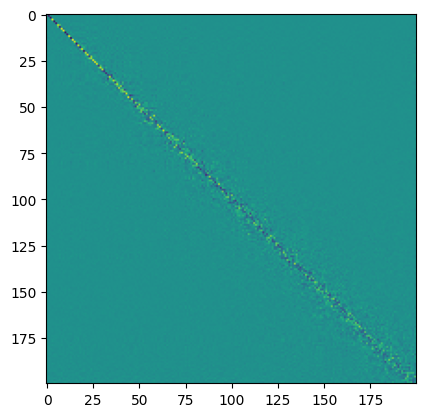

In [162]:
import matplotlib.pyplot as plt
plt.imshow(Cxy[0].cpu().numpy())

In [163]:
from src.utils.fmap import fmap2pointmap_vectorized

p2p_fill = fmap2pointmap_vectorized(
    Cxy=Cxy,
    evecs_x=data['first']['evecs'],
    evecs_y=data['second']['evecs'],
    verts_mask_x=data['first']['verts_mask'],
    verts_mask_y=data['second']['verts_mask'],
)
p2p_fill

tensor([[   0,    1,   96,  ..., 1949, 1849,   -1],
        [   0,   16,   96,  ..., 1925, 1925,   -1],
        [  70,   28,    3,  ..., 1947, 1905,   -1],
        ...,
        [  70,   28,    3,  ..., 4355, 4411,   -1],
        [  70,    1,    3,  ..., 1947, 1905, 2161],
        [   1,    1,    3,  ..., 4415, 4458,   -1]], device='cuda:0')

In [164]:
batch_idx, y_no_corr = torch.where(p2p == -1)
batch_idx, y_no_corr

(tensor([0, 0, 0,  ..., 7, 7, 7], device='cuda:0'),
 tensor([   4,   18,   35,  ..., 4998, 4999, 5000], device='cuda:0'))

In [165]:
p2p_merge = p2p.clone()
p2p_merge[batch_idx, y_no_corr] = p2p_fill[batch_idx, y_no_corr]
torch.where(p2p_merge == -1)

(tensor([0, 1, 2, 3, 4, 4, 4, 5, 7], device='cuda:0'),
 tensor([5000, 5000, 5000, 5000, 4998, 4999, 5000, 5000, 5000], device='cuda:0'))

In [166]:
from src.utils.fmap import pointmap2Pyx_smooth_vectorized

Pyx_fill = pointmap2Pyx_smooth_vectorized(
    p2p=p2p_merge,
    evecs_x=data['first']['evecs'],
    evecs_y=data['second']['evecs'],
    evecs_trans_x=data['first']['evecs_trans'],
    evecs_trans_y=data['second']['evecs_trans'],
)

Pyx_fill.sum(axis=-1), Pyx_fill.sum(axis=-2)

(tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000]],
        device='cuda:0'),
 tensor([[0.9039, 0.8410, 1.2708,  ..., 0.4634, 1.0005, 1.2899],
         [1.0259, 1.0555, 1.3678,  ..., 0.9539, 1.5514, 1.9749],
         [0.8286, 1.0719, 1.1322,  ..., 1.5865, 0.8057, 1.7211],
         ...,
         [0.6702, 0.8791, 0.9646,  ..., 1.2346, 0.6956, 0.8923],
         [0.7507, 0.9570, 1.1263,  ..., 1.2530, 1.2627, 1.8599],
         [0.8272, 0.9883, 1.3445,  ..., 1.4035, 1.2375, 0.8564]],
        device='cuda:0'))

In [167]:
import pyvista as pv
pv.set_jupyter_backend('html')

from src.utils.fmap import pointmap2Pyx_vectorized, pointmap2Pyx_smooth_vectorized
from src.utils.texture import write_obj_pair
from src.utils.tensor import to_numpy

output_path = Path('output/gt-texture-transfer')
output_path.mkdir(parents=True, exist_ok=True)

Pyx = pointmap2Pyx_smooth_vectorized(
    # p2p=p2p_fill,
    p2p=p2p_merge,
    evecs_x = data['first']['evecs'],
    evecs_y = data['second']['evecs'],
    evecs_trans_x = data['first']['evecs_trans'],
    evecs_trans_y = data['second']['evecs_trans'],
)

# Pyx = pointmap2Pyx_vectorized(
#     p2p=p2p_fill,
#     num_verts_x = data['first']['num_verts'],
#     num_verts_y = data['second']['num_verts'],
# )

name_x, name_y = data['first']['name'], data['second']['name']
verts_num_x = data['first']['num_verts']
verts_num_y = data['second']['num_verts']
faces_num_x = data['first']['num_faces']
faces_num_y = data['second']['num_faces']

for idx in range(len(data['first']['name'])):
    # export mesh w/ texture
    write_obj_pair(
        file_name1=str(output_path / f'{name_x[idx]}.obj'),
        file_name2=str(output_path / f'{name_x[idx]}--{name_y[idx]}.obj'),
        faces1=to_numpy(data['first']['faces'][idx, :faces_num_x[idx]]),
        verts1=to_numpy(data['first']['verts'][idx, :verts_num_x[idx]]),
        verts2=to_numpy(data['second']['verts'][idx, :verts_num_y[idx]]),
        faces2=to_numpy(data['second']['faces'][idx, :faces_num_y[idx]]),
        Pyx=to_numpy(Pyx[idx, :verts_num_y[idx], :verts_num_x[idx]]),
        texture_file=str(output_path / 'texture.png'),
    )

    # render texture transfer
    pl = pv.Plotter(off_screen=True)
    pl.add_mesh(
        mesh=pv.read(output_path / f'{name_x[idx]}.obj'),
        texture=pv.read_texture(output_path / 'texture.png'),
    )
    pl.add_mesh(
        mesh=pv.read(output_path / f'{name_x[idx]}--{name_y[idx]}.obj').translate([1, 0, 0]),
        texture=pv.read_texture(output_path / 'texture.png'),
    )
    pl.camera_position = 'xy'
    pl.screenshot(output_path / f'{idx}', window_size=[1024, 1024], return_img=False)
    pl.close()

    # # remove the mesh files if not needed
    # (output_path / f'{name_x[idx]}.obj').unlink(missing_ok=True)
    # (output_path / f'{name_x[idx]}.mtl').unlink(missing_ok=True)
    # (output_path / f'{name_x[idx]}--{name_y[idx]}.obj').unlink(missing_ok=True)
    # (output_path / f'{name_x[idx]}--{name_y[idx]}.mtl').unlink(missing_ok=True)

### UV interpolation based on RBF

In [156]:
batch_idx, y_no_corr = torch.where(p2p == -1)

Pyx = pointmap2Pyx_vectorized(
    p2p=p2p,
    num_verts_x = data['first']['num_verts'],
    num_verts_y = data['second']['num_verts'],
)

# mark the missing points in Pyx
Pyx[batch_idx, y_no_corr] = -1

In [157]:
import pyvista as pv
pv.set_jupyter_backend('html')
from scipy.interpolate import RBFInterpolator
from src.utils.texture import generate_tex_coords, write_obj_with_texture

B = len(data['first']['verts'])

for idx in range(B):
    # get vals
    file_name1=str(output_path / f'{name_x[idx]}.obj')
    file_name2=str(output_path / f'{name_x[idx]}--{name_y[idx]}.obj')
    faces1=to_numpy(data['first']['faces'][idx, :faces_num_x[idx]])
    verts1=to_numpy(data['first']['verts'][idx, :verts_num_x[idx]])
    verts2=to_numpy(data['second']['verts'][idx, :verts_num_y[idx]])
    faces2=to_numpy(data['second']['faces'][idx, :faces_num_y[idx]])
    evecs_y = data['second']['evecs'][idx]
    evecs_trans_y = data['second']['evecs_trans'][idx]
    texture_file=str(output_path / 'texture.png')

    # uv coords
    uv1 = generate_tex_coords(verts1)
    uv2 = torch.tensor((Pyx[idx]).cpu().numpy() @ uv1).to(device)

    # interpolate missing uv coords
    y_no_corr = torch.where(p2p[idx, :verts_num_y[idx]] == -1)[0]
    y_has_corr = torch.where(p2p[idx, :verts_num_y[idx]] != -1)[0]

    points = verts2[y_has_corr.cpu().numpy()]
    u_vals = uv2[y_has_corr, 0]
    v_vals = uv2[y_has_corr, 1]
    
    rbf_u = RBFInterpolator(points, u_vals.cpu().numpy(), kernel='thin_plate_spline')
    rbf_v = RBFInterpolator(points, v_vals.cpu().numpy(), kernel='thin_plate_spline')

    uv2[y_no_corr, 0] = torch.tensor(rbf_u(verts2[y_no_corr.cpu().numpy()]), dtype=uv2.dtype).to(device)
    uv2[y_no_corr, 1] = torch.tensor(rbf_v(verts2[y_no_corr.cpu().numpy()]), dtype=uv2.dtype).to(device)

    # smooth uv coords via spectral reconstruction
    uv2_smooth = evecs_y @ evecs_trans_y @ uv2

    # export mesh w/ texture
    output_path = Path('output/gt-texture-transfer')
    output_path.mkdir(parents=True, exist_ok=True)

    write_obj_with_texture(verts1, faces1, file_name1, uv1, texture_file)
    write_obj_with_texture(verts2, faces2, file_name2, uv2_smooth, texture_file)

    # render texture transfer
    pl = pv.Plotter(off_screen=True)
    pl.add_mesh(
        mesh=pv.read(output_path / f'{name_x[idx]}.obj'),
        texture=pv.read_texture(output_path / 'texture.png'),
    )
    pl.add_mesh(
        mesh=pv.read(output_path / f'{name_x[idx]}--{name_y[idx]}.obj').translate([1, 0, 0]),
        texture=pv.read_texture(output_path / 'texture.png'),
    )
    pl.camera_position = 'xy'
    pl.screenshot(output_path / f'{idx}', window_size=[1024, 1024], return_img=False)
    pl.close()

## Benchmarking ground-truth correspondence

Surprisingly, the ground-truth `p2p` has a ~4.5 geodesic error on the remeshed FAUST dataset!

In [153]:
from src.metric.geodist import GeodesicDist_vectorized

geodist = GeodesicDist_vectorized()
err = geodist.geodesic_error(
    dist_x=data['first']['dist'],
    corr_x=data['first']['corr'],
    corr_y=data['second']['corr'],
    # p2p=p2p_fill,
    p2p=p2p_merge,
)
err.shape, err, err.mean()

(torch.Size([8, 5000]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0169, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0114],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0114],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0103]],
        device='cuda:0'),
 tensor(0.0046, device='cuda:0'))

In [ ]:
# mean geodist of nearest neighbor
data['first']['dist'].sort(dim=-1)[0][:, :, 1].mean()

tensor(0.0120, device='cuda:0')